##  Testing Assumptions
1. State assumptions
2. Check assumptions (with figures)
    1. residuals
    2. correlations
    3. \# of modes
 
### Step 1: State assumptions

1. We assume that graphs are sampled according to: $x_i \stackrel{iid}{\sim} F$. This is both an independent and identical assumption.

2. We assume that edges in the graphs are independent: $F_{X|0} = ER(p_0) = Bern(p_0)^{V \times V}$.

3. We assume there is a class conditional difference across subject genders.

### Step 2: Check assumptions

For independent graphs, check that off diagonal covariance is approximately 0. <br/>
$x_i \stackrel{iid}{\sim} F$<br/>
$(x_1, x_2, ..., x_n) \sim F = \prod_i^n F_i$ <br/>
$F_i = F_j, \forall i,j$


For identical graphs, check the optimal number of clusters and see if that is 1. <br/>
$F = \prod_j^J F_j, J < n$ <br/>
$\prod_j^J w_jF_j(\theta)$ <br/>

For iid edges, repeat the above on population of all edges (covariance between edges)<br/>
$F_{X|0} = ER(p_0) = Bern(p_0)^{V \times V}$ <br/>
$F_{X|1} = ER(p_1) = Bern(p_1)^{V \times V}$

For class differences, fit the model using least squares regression. See if the model is normal and plot $\hat{y}$ vs. $y$.<br/>
$y = \beta x + \epsilon$, $\epsilon \sim \mathcal{N}(\mu, \epsilon)$ <br/>
$||y - \beta x|| - \epsilon \sim \mathcal{N}$<br/>
$p_1 \neq p_2$


### Setup Step

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import igraph as ig

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

# Initializing dataset names
dnames = list(['../data/desikan/KKI2009'])
print "Dataset: " + ", ".join(dnames)

# Getting graph names
fs = list()
for dd in dnames:
        fs.extend([root+'/'+file for root, dir, files in os.walk(dd) for file in files])
fs = fs[:]
def loadGraphs(filenames, rois, printer=False):
    A = np.zeros((rois, rois, len(filenames)))
    for idx, files in enumerate(filenames):
        if printer:
            print "Loading: " + files
        g = ig.Graph.Read_GraphML(files)
        tempg = g.get_adjacency(attribute='weight')
        A[:,:,idx] = np.asarray(tempg.data)
        
    return A

# Load X
X = loadGraphs(fs, 70)
print X.shape

# Load Y
ys = csv.reader(open('../data/kki42_subjectinformation.csv'))
y = [y[5] for y in ys]
y = [1 if x=='F' else 0 for x in y[1:]]

Dataset: ../data/desikan/KKI2009
(70, 70, 42)


#### Independent Graph Assumption

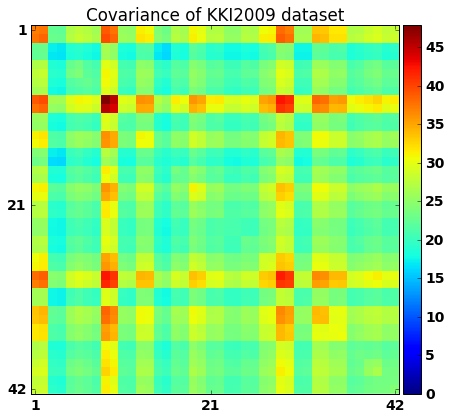

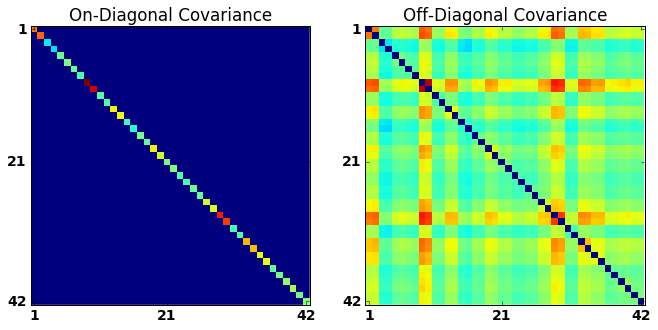

Ratio of on- and off-diagonal determinants: -0.482411193732


In [34]:
vectorized = np.reshape(X, (X.shape[0]**2, X.shape[2])).T
covar = np.cov(vectorized)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

plt.figure(figsize=(7,7))
ax = plt.gca()

im = ax.imshow(covar/100000, interpolation='None')
im.set_clim([0, np.max(covar/100000)])

plt.title('Covariance of KKI2009 dataset')
plt.xticks((0, 20, 41), ('1', '21', '42'))
plt.yticks((0, 20, 41), ('1', '21', '42'))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig('../figs/graphs_covariance.png')
plt.show()

diag = covar.diagonal()*np.eye(covar.shape[0])
hollow = covar-diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

plt.figure(figsize=(11,8))
plt.subplot(121)
plt.imshow(diag/100000, interpolation='None')
plt.clim([0, np.max(covar/100000)])
plt.title('On-Diagonal Covariance')
plt.xticks((0, 20, 41), ('1', '21', '42'))
plt.yticks((0, 20, 41), ('1', '21', '42'))


plt.subplot(122)
plt.imshow(hollow/100000, interpolation='None')
plt.clim([0, np.max(covar/100000)])
plt.title('Off-Diagonal Covariance')
plt.xticks((0, 20, 41), ('1', '21', '42'))
plt.yticks((0, 20, 41), ('1', '21', '42'))
plt.show()

print "Ratio of on- and off-diagonal determinants: " + str(d_det/h_det)

From the above, we conclude that the assumption that the graphs were independent is false. This is because the off-diagonal components of the covariance are highly significant in the cross-graph covariance matrix.

#### Identical Graph Assumption

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.
Fitting and evaluating model with 15 clusters.


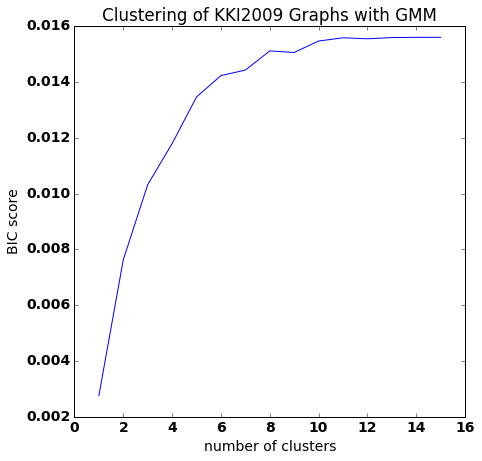

[ 3625489.06541763  1311273.92601775   969072.23280772   848052.65413098
   742768.00510504   702730.0468214    693160.44027992   661649.64679714
   664067.4568349    646531.97528178   641632.76546966   643138.50040123
   641341.17993333   640943.72444089   640961.27790544]


In [33]:
import sklearn.mixture
i = np.linspace(1,15,15,dtype='int')
print i
bic = np.array(())
for idx in i:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag')
    gmm.fit(vectorized.T)
    bic = np.append(bic, gmm.bic(vectorized.T))
plt.figure(figsize=(7,7))
plt.plot(i, 10000/bic)
plt.title('Clustering of KKI2009 Graphs with GMM')
plt.ylabel('BIC score')
plt.xlabel('number of clusters')
plt.savefig('../figs/graphs_identical.png')
plt.show()
print bic

From the above we observe that, since the elbow of the bic curve lies at 6, that our data may not have been sampled identically from one distribution. This assumption based on the evidence provided is also false.

#### Independent Edge Assumption

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


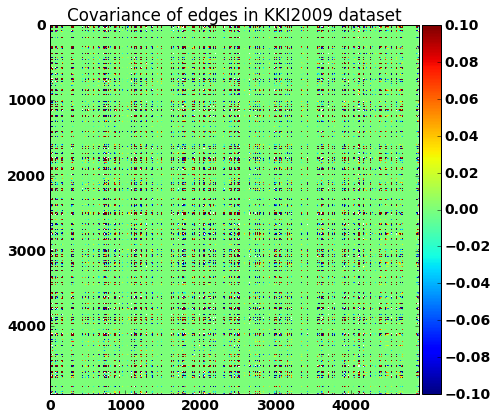

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in log


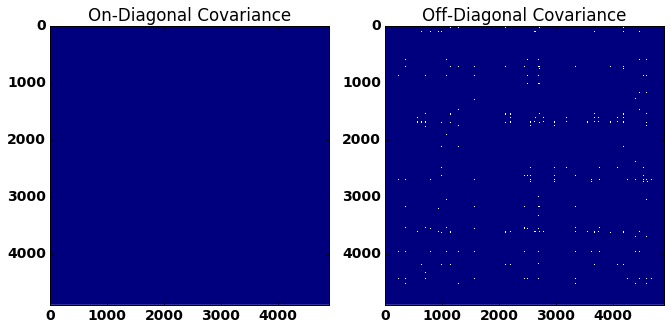

Ratio of on- and off-diagonal determinants: nan


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


In [39]:
vect = np.reshape(X, (X.shape[0]**2, X.shape[2]))
covar = np.cov(vect)

plt.figure(figsize=(7,7))
ax = plt.gca()

im = ax.imshow(np.log(covar/100000+1), interpolation='None')
im.set_clim([0, np.max(np.log(covar/100000))])

plt.title('Covariance of edges in KKI2009 dataset')
# plt.xticks((0, 20, 41), ('1', '21', '42'))
# plt.yticks((0, 20, 41), ('1', '21', '42'))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig('../figs/edges_covariance.png')
plt.show()

diag = covar.diagonal()*np.eye(covar.shape[0])
hollow = covar-diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

plt.figure(figsize=(11,8))
plt.subplot(121)
plt.imshow(np.log(diag/100000+1), interpolation='None')
plt.clim([0, np.max(np.log(covar/100000+1))])
plt.title('On-Diagonal Covariance')
# plt.xticks((0, 20, 41), ('1', '21', '42'))
# plt.yticks((0, 20, 41), ('1', '21', '42'))


plt.subplot(122)
plt.imshow(np.log(hollow/100000+1), interpolation='None')
plt.clim([0, np.max(np.log(covar/100000+1))])
plt.title('Off-Diagonal Covariance')
# plt.xticks((0, 20, 41), ('1', '21', '42'))
# plt.yticks((0, 20, 41), ('1', '21', '42'))
plt.show()

print "Ratio of on- and off-diagonal determinants: " + str(d_det/h_det)

From the above, we can conclude that the edges are not independent of one another, as the ratio of on- to off-diagonal covariance is very small. This assumption is false.

#### Identical Edge Assumption

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.
Fitting and evaluating model with 15 clusters.


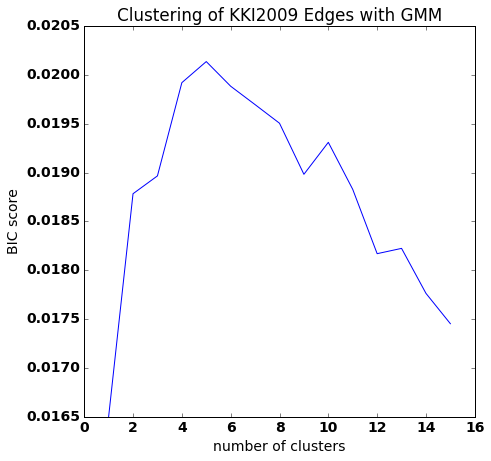

[ 606050.29134651  532357.69714136  527229.80320276  501964.48717751
  496579.51227793  502885.40210039  507693.64890837  512653.61512745
  526775.90654774  517848.9236964   531095.85993598  550341.82749754
  548704.86437526  562938.88304541  572960.13668072]


In [40]:
import sklearn.mixture
i = np.linspace(1,15,15,dtype='int')
print i
bic = np.array(())
for idx in i:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag')
    gmm.fit(vect.T)
    bic = np.append(bic, gmm.bic(vect.T))
plt.figure(figsize=(7,7))
plt.plot(i, 10000/bic)
plt.title('Clustering of KKI2009 Edges with GMM')
plt.ylabel('BIC score')
plt.xlabel('number of clusters')
plt.savefig('../figs/edges_identical.png')
plt.show()
print bic

Looking at the bic curve, we observe that the optimal number of clusters is 5, indicating that edges are not in fact identically distributed. This assumptions appears to be false.

#### Class Conditional Edge Probability Assumption

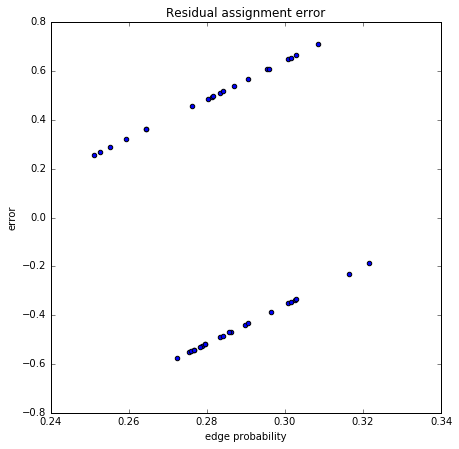

In [173]:
import scipy.stats as ss
ya = np.array(y)

# clf = sklm.LinearRegression()
# print vectorized.T.shape
edgeprob = 1.0*np.sum(1.0*(vectorized.T>0),1)/4900
# print edgeprob
# print ya.shape
# vals = clf.fit(edgeprob.T, ya)
# slope = clf.coef_
# intercept = clf.intercept_

vals = ss.linregress(edgeprob, ya)
m = vals[0]
c = vals[1]



def comp_value(m, c, data):
    return m.T*data + c

resi = np.array(())
for idx, subj in enumerate(ya):
    temp = comp_value(m, c, edgeprob[idx])
    resi = np.append(resi, subj - temp)
    
plt.figure(figsize=(7,7))
plt.scatter(edgeprob, resi)
plt.title('Residual assignment error')
plt.xlabel('edge probability')
plt.ylabel('error')
plt.show()

From the above we can see quite plainly that our classifier fails to separate subjects based on their edge probability. Thus, this assumption is also false.

#### Class covariances are different

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log


(70, 70, 22)
(70, 70, 20)


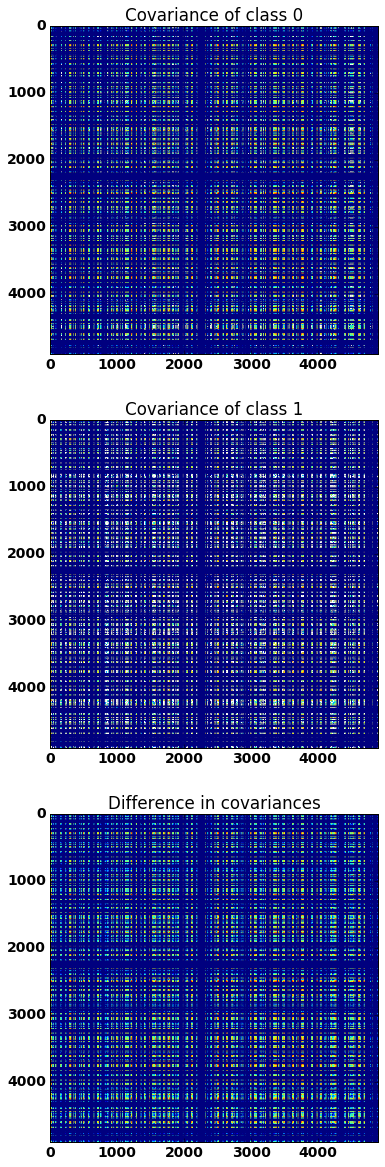

In [43]:
g_0 = np.zeros((70, 70, sum([1 if x == 0 else 0 for x in y])))
g_1 = np.zeros((70, 70, sum([1 if x == 1 else 0 for x in y])))

c0=0
c1=0
for idx, val in enumerate(y):
    if val == 0:
        g_0[:,:,c1] = X[:,:,idx]
        c0 += 1
    else:
        g_1[:,:,c1] = X[:,:,idx]
        c1 +=1
print g_0.shape
print g_1.shape

vect_0 = np.reshape(g_0, (g_0.shape[0]**2, g_0.shape[2]))
covar_0 = np.cov(vect_0)
vect_1 = np.reshape(g_1, (g_1.shape[0]**2, g_1.shape[2]))
covar_1 = np.cov(vect_1)

plt.figure(figsize=(10,20))
plt.subplot(311)
plt.imshow(np.log(covar_0+1))
plt.clim([0, np.log(np.max(np.max(covar_0)))])
plt.title('Covariance of class 0')
plt.subplot(312)
plt.imshow(np.log(covar_1+1))
plt.clim([0, np.log(np.max(np.max(covar_0)))])
plt.title('Covariance of class 1')
plt.subplot(313)
plt.imshow(np.log(abs(covar_1 - covar_0 +1)))
plt.clim([0, np.log(np.max(np.max(covar_0)))])
plt.title('Difference in covariances')
plt.savefig('../figs/class_covariance.png')
plt.show()


As the difference in covariances is large, we can see why QDA performed better than LDA for this clustering assignment.